In [24]:
import re
import os
import nltk
from nltk.corpus import stopwords


import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dense, Input, Flatten
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score,confusion_matrix

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [3]:
df = pd.read_csv(r"IMDB Dataset.csv")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
data = df.sample(n=20000)

In [6]:
ps = nltk.PorterStemmer()
wl = nltk.WordNetLemmatizer()

In [7]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z\s]','',text)
    stop = stopwords.words('english')
    text = [ps.stem(wl.lemmatize(word)) for word in text.split() if word not in stop]
    return text
    

In [8]:
processed_data = data['review'].map(preprocess)

In [9]:
processed_data.head()

14560    [monstervis, show, grew, late, night, host, pe...
16727    [realli, great, film, get, think, parent, frag...
1956     [tune, thing, one, night, cabl, channel, minut...
8214     [excel, exampl, entreatingli, bad, bmovi, wors...
19649    [happen, catch, last, minut, moviel, night, ye...
Name: review, dtype: object

In [10]:
data['sentiment'].value_counts()

sentiment
positive    10019
negative     9981
Name: count, dtype: int64

In [11]:
# Tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(processed_data)
sequences = tokenizer.texts_to_sequences(processed_data)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 80002 unique tokens.


In [12]:
data.loc[data['sentiment'] == 'positive','sentiment'] = 1
data.loc[data['sentiment'] == 'negative','sentiment'] = 0
labels = np.asarray(data['sentiment']).astype(np.float32)
labels

array([1., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [13]:
features = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)

features.shape, labels.shape

((20000, 100), (20000,))

In [14]:
x_train, x_test, y_train, y_test = train_test_split( features, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( features, labels, test_size=0.50, random_state=4)
x_train.shape, y_train.shape

((16000, 100), (16000,))

In [15]:
embedding_index = {}
with open(r"glove.6B.100d.txt", encoding = 'utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:] ,dtype='float32')
        
        embedding_index[word] = vector
        

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [16]:

convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(128,fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)   
l_merge = Concatenate()(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
# l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(1, activation='sigmoid')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             8000300   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 98, 128)              38528     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 97, 128)              51328     ['embedding[0][0]']           
                                                                                              

In [17]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=15, batch_size=150, verbose=1)

Epoch 1/15
107/107 [==============================] - 154s 1s/step - loss: 0.6435 - acc: 0.6309 - val_loss: 0.4703 - val_acc: 0.7763
Epoch 2/15
107/107 [==============================] - 89s 830ms/step - loss: 0.3807 - acc: 0.8332 - val_loss: 0.2987 - val_acc: 0.8731
Epoch 3/15
107/107 [==============================] - 79s 740ms/step - loss: 0.2117 - acc: 0.9174 - val_loss: 0.1564 - val_acc: 0.9497
Epoch 4/15
107/107 [==============================] - 79s 737ms/step - loss: 0.0761 - acc: 0.9772 - val_loss: 0.0983 - val_acc: 0.9685
Epoch 5/15
107/107 [==============================] - 78s 727ms/step - loss: 0.0157 - acc: 0.9976 - val_loss: 0.1031 - val_acc: 0.9697
Epoch 6/15
107/107 [==============================] - 74s 695ms/step - loss: 0.0029 - acc: 0.9999 - val_loss: 0.1162 - val_acc: 0.9714
Epoch 7/15
107/107 [==============================] - 75s 703ms/step - loss: 9.8015e-04 - acc: 0.9999 - val_loss: 0.1264 - val_acc: 0.9708
Epoch 8/15
107/107 [==============================] -

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


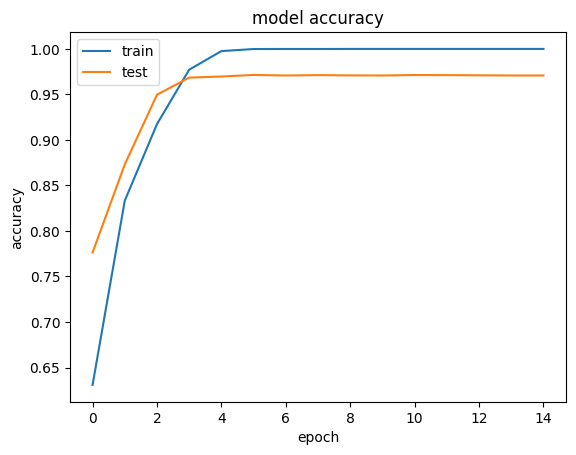

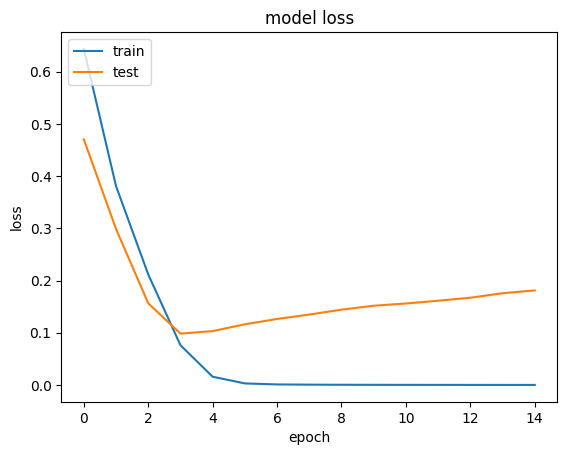

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
y_pred = model.predict(x_test, verbose = 1)

313/313 [==============================] - 6s 18ms/step


In [20]:
y_pred

array([[9.4798241e-07],
       [6.9008665e-10],
       [4.6176899e-07],
       ...,
       [9.9999750e-01],
       [1.0000000e+00],
       [2.4714072e-10]], dtype=float32)

In [21]:
def fx(num):
    if num >= 0.5:
        return 1
    else:
        return 0

arr = np.asarray(list(map(fx,y_pred)))
ans = np.asarray(y_test)

In [22]:
f1 = f1_score(arr,ans, zero_division=1.0,average='weighted')
r1 = recall_score(arr,ans, zero_division=1.0,average='weighted')
p1 = precision_score(arr,ans, zero_division=1.0,average='weighted')
acc = accuracy_score(arr,ans)
print('f1',f1)
print('recall',r1)
print('precision',p1)
print('acc',acc)

f1 0.9679999155183645
recall 0.968
precision 0.9680005280132001
acc 0.968


In [25]:
cm = confusion_matrix(arr, ans)
cm

array([[4818,  163],
       [ 157, 4862]], dtype=int64)